In [183]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [184]:
from torch import nn

class TorchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4096, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.linear3 = nn.Linear(512, 40)
        self.drop = nn.Dropout(p=0.3)
        self.act = nn.ReLU()

    # forward 前向运算 (nn.Module方法重写)
    def forward(self, input_tensor):
        out = self.linear1(input_tensor)
        out = self.bn1(out)
        out = self.act(out)
        out = self.drop(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out = self.act(out)
        out = self.drop(out)
        final = self.linear3(out) # shape

        return final

In [185]:
import sklearn.datasets as datasets

data = datasets.fetch_olivetti_faces(data_home='./olivetti', shuffle=True)

[ name for name in data]

['data', 'images', 'target', 'DESCR']

In [186]:
# 分割list
def split_data(data, test_size):
    train_size = len(data) - test_size
    return torch.utils.data.random_split(data, [train_size,test_size])
# 转化为张量
def to_tensor(data, device=device):
    return torch.tensor(data).to(device=device)
# 转化为DataLoader
def to_dataloader(data, batch_size):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
# 分割数据集并转为DataLoader
def to_dataloaders(data, target, batch_size, test_size):
    dataset = [(features,label) for features,label in zip(to_tensor(data), to_tensor(target))]
    train_dataset,test_dataset = split_data(dataset, test_size)
    return to_dataloader(train_dataset, batch_size),to_dataloader(test_dataset, batch_size)
    

In [187]:
# 定义超参数
LR = 1e-3
EPOCH = 25
BATCH_SIZE = 128
TEST_SIZE = 100

# 训练和测试
def train_test(model, optimizer, loss_fn, data=data, batch_size=BATCH_SIZE, test_size=TEST_SIZE, epoch=EPOCH):
    dataloader, test_dl = to_dataloaders(data.data, data.target, batch_size, test_size)
    res = []
    # 正则化&归一化生效
    model.train()
    for epoch in range(epoch):
        # 提取训练数据
        for data, target in dataloader:
            # 前向运算
            output = model(data)
            # 计算损失
            loss = loss_fn(output, target)
            # 反向传播
            model.zero_grad()  # 所有参数梯度清零
            loss.backward()     # 计算梯度（参数.grad）
            optimizer.step()    # 更新参数
        if epoch % 4 == 0:
            res.append(f'Epoch:{epoch} Loss: {loss.item()}')
    
    correct = 0
    total = 0
    model.eval() # train(False)
    with torch.no_grad():  # 不计算梯度
        for data, target in test_dl:
            output = model(data)
            _, predicted = torch.max(output, 1)  # 返回每行最大值和索引
            total += target.size(0)  # size(0) 等效 shape[0]
            correct += (predicted == target).sum().item()
    
    res.append(f'Accuracy: {correct} / {total} = {correct/total*100}%')
    return res

SGD - CrossEntropyLoss
['Epoch:0 Loss: 3.7699599266052246', 'Epoch:4 Loss: 3.683147668838501', 'Epoch:8 Loss: 3.5004518032073975', 'Epoch:12 Loss: 3.3273203372955322', 'Epoch:16 Loss: 3.286910057067871', 'Epoch:20 Loss: 2.9920904636383057', 'Epoch:24 Loss: 2.841641426086426', 'Accuracy: 46 / 100 = 46.0%']
SGD - NLLLoss
['Epoch:0 Loss: 0.007948948070406914', 'Epoch:4 Loss: -0.20497506856918335', 'Epoch:8 Loss: -0.4499041736125946', 'Epoch:12 Loss: -0.5972714424133301', 'Epoch:16 Loss: -0.7475637197494507', 'Epoch:20 Loss: -0.8533832430839539', 'Epoch:24 Loss: -1.0630236864089966', 'Accuracy: 35 / 100 = 35.0%']
SGD momentum - CrossEntropyLoss
['Epoch:0 Loss: 3.7513723373413086', 'Epoch:4 Loss: 3.204129934310913', 'Epoch:8 Loss: 2.6355631351470947', 'Epoch:12 Loss: 2.414031744003296', 'Epoch:16 Loss: 2.1213929653167725', 'Epoch:20 Loss: 1.7776050567626953', 'Epoch:24 Loss: 1.6620310544967651', 'Accuracy: 78 / 100 = 78.0%']
SGD momentum - NLLLoss
['Epoch:0 Loss: -0.0369117297232151', 'Epoc

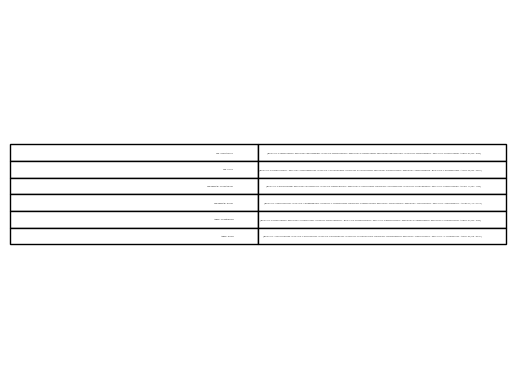

In [188]:
import matplotlib.pyplot as plt
import numpy as np

# 优化器
optimizers = {
    'SGD': lambda model: torch.optim.SGD(model.parameters(), lr=LR),
    'SGD momentum': lambda model: torch.optim.SGD(model.parameters(), lr=LR, momentum=0.8),
    'AdamW': lambda model: torch.optim.AdamW(model.parameters(), lr=LR)
}
# 损失函数
loss_fns = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'NLLLoss': nn.NLLLoss(),
}
cellText = []
for optim in optimizers:
    for loss_fn in loss_fns:
        print(f'{optim} - {loss_fn}')
        model = TorchNN().to(device=device)
        res = train_test(model, optimizers[optim](model), loss_fns[loss_fn])
        print(res)
        cellText.append([f'{optim} - {loss_fn}', res])


fig, ax = plt.subplots()
ax.axis('off')
ax.table(cellText=cellText, loc='center')

plt.show()